# Heart sound classification using UrbanSoundClassif Codebase


In [1]:
import glob
import os
import librosa
import librosa.display
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
from keras.utils.np_utils import to_categorical
from sklearn.metrics import precision_recall_fscore_support

Using TensorFlow backend.


In [2]:
def load_sound_files(file_paths):
    raw_sounds = []
    for fp in file_paths:
        X,sr = librosa.load(fp)
        raw_sounds.append(X)
    return raw_sounds

def plot_waves(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25, 60))
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(10,1,i)
        librosa.display.waveplot(np.array(f),sr=22050)
        plt.title(n.title())
        i += 1
    plt.suptitle('Figure 1: Waveplot',x=0.5, y=0.915,fontsize=1)
    plt.show()
    
def plot_specgram(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25, 60))
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(10,1,i)
        specgram(np.array(f), Fs=22050)
        plt.title(n.title())
        i += 1
    plt.suptitle('Figure 2: Spectrogram',x=0.5, y=0.915,fontsize=1)
    plt.show()

def plot_log_power_specgram(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25, 60))
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(10,1,i)
        D = librosa.amplitude_to_db(np.abs(librosa.stft(f))**2, ref=np.max)
        librosa.display.specshow(D,x_axis='time' ,y_axis='log')
        plt.title(n.title())
        i += 1
    plt.suptitle('Figure 3: Log power spectrogram',x=0.5, y=0.915,fontsize=1)
    plt.show()
    
    


In [3]:
def extract_feature(file_name):
    X, sample_rate = librosa.load(file_name)
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
    return mfccs,chroma,mel,contrast,tonnetz

def parse_audio_files(parent_dir,sub_dirs,file_ext='*.wav'):
    features, labels = np.empty((0,193)), np.empty(0)
    for label, sub_dir in enumerate(sub_dirs):
        for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
            mfccs, chroma, mel, contrast,tonnetz = extract_feature(fn)
            ext_features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
            features = np.vstack([features,ext_features]) 
            labels = np.append(labels, fn.split('/')[6].split('-')[2][0])
    return np.array(features), np.array(labels, dtype = np.int)

def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels,n_unique_labels))
    #one_hot_encode = to_categorical(labels, num_classes=3)
    one_hot_encode[np.arange(n_labels), labels] = 1
    print(one_hot_encode)
    return one_hot_encode

In [ ]:
parent_dir = 'C:/Users/apt/Desktop/Data/training/training-a'
sub_dirs = ['fold-1','fold-2']
features, labels = parse_audio_files(parent_dir,sub_dirs)

C:\Users\apt\Anaconda3\envs\ml\lib\site-packages\librosa\core\pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


In [ ]:
#labels = one_hot_encode(labels)
labels = tf.keras.utils.to_categorical(labels)
train_test_split = np.random.rand(len(features)) < 0.70
train_x = features[train_test_split]
train_y = labels[train_test_split]
test_x = features[~train_test_split]
test_y = labels[~train_test_split]


In [ ]:
training_epochs = 10000
n_dim = features.shape[1]
print(features.shape)
print(features.shape[1])
n_classes = 3
n_hidden_units_one = 280 
n_hidden_units_two = 300
sd = 1 / np.sqrt(n_dim)
learning_rate = 0.01

In [ ]:
X = tf.placeholder(tf.float32,[None,n_dim])
Y = tf.placeholder(tf.float32,[None,n_classes])

W_1 = tf.Variable(tf.random_normal([n_dim,n_hidden_units_one], mean = 0, stddev=sd))
b_1 = tf.Variable(tf.random_normal([n_hidden_units_one], mean = 0, stddev=sd))
h_1 = tf.nn.tanh(tf.matmul(X,W_1) + b_1)


W_2 = tf.Variable(tf.random_normal([n_hidden_units_one,n_hidden_units_two], mean = 0, stddev=sd))
b_2 = tf.Variable(tf.random_normal([n_hidden_units_two], mean = 0, stddev=sd))
h_2 = tf.nn.sigmoid(tf.matmul(h_1,W_2) + b_2)


W = tf.Variable(tf.random_normal([n_hidden_units_two,n_classes], mean = 0, stddev=sd))
b = tf.Variable(tf.random_normal([n_classes], mean = 0, stddev=sd))
y_ = tf.nn.softmax(tf.matmul(h_2,W) + b)

init = tf.global_variables_initializer()

In [ ]:
cost_function = tf.reduce_mean(-tf.reduce_sum(Y * tf.log(y_), reduction_indices=[1])) 
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_function)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [ ]:
cost_history = np.empty(shape=[1],dtype=float)
y_true, y_pred = None, None
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(training_epochs):            
        _,cost = sess.run([optimizer,cost_function],feed_dict={X:train_x,Y:train_y})
        cost_history = np.append(cost_history,cost)
    
    y_pred = sess.run(tf.argmax(y_,1),feed_dict={X: test_x})
    y_true = sess.run(tf.argmax(test_y,1))

In [ ]:
fig = plt.figure(figsize=(10,8))
plt.plot(cost_history)
plt.ylabel("Cost")
plt.xlabel("Iterations")
plt.axis([0,training_epochs,0,np.max(cost_history)])
plt.show()

p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
print("F-Score:", round(f,3))

# Urban sound classification 

In [4]:
def extract_feature(file_name):
    X, sample_rate = librosa.load(file_name)
    print ("Features :",len(X), "sampled at ", sample_rate, "hz")
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
    return mfccs,chroma,mel,contrast,tonnetz

def parse_audio_files(parent_dir,sub_dirs,file_ext='*.wav'):
    features, labels = np.empty((0,193)), np.empty(0)
    for label, sub_dir in enumerate(sub_dirs):
        for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
            try:
                mfccs, chroma, mel, contrast, tonnetz = extract_feature(fn)
                ext_features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
                features = np.vstack([features,ext_features])
                labels = np.append(labels, fn.split('fold')[1].split('-')[1])
            except:
                print("Error processing " + fn + " - skipping")
    return np.array(features), np.array(labels, dtype = np.int)

In [ ]:
def save_folds(data_dir):
    for k in range(1,11):
        fold_name = 'fold' + str(k)
        print("\nSaving " + fold_name)
        features, labels = parse_audio_files(data_dir, [fold_name])
        labels = tf.keras.utils.to_categorical(labels)
        
        print ("Features of", fold_name , " = ", features.shape)
        print ("Labels of", fold_name , " = ", labels.shape)
        
        feature_file = os.path.join(data_dir, fold_name + '_x.npy')
        labels_file = os.path.join(data_dir, fold_name + '_y.npy')
        np.save(feature_file, features)
        print ("Saved " + feature_file)
        np.save(labels_file, labels)
        print ("Saved " + labels_file)
    
# uncomment this to recreate and save the feature vectors
# data_dir = "Where you have saved the UrbanSound8K data set"       
save_dir = "C:/Users/apt/Desktop/Data/UrbanSound8K/audio/"
# assure_path_exists(save_dir)
save_folds(save_dir)

This code below loads previously computed numpy features for each of the 10 folds, we'll use the first 8 for training, and keep one back for validation and one for testing.

In [5]:
data_dir = "C:/Users/apt/Desktop/Data/UrbanSound8K/audio/"
def add_folds():
    subsequent_fold = False
    for k in range(1,9):
        fold_name = 'fold' + str(k)
        print( "\nAdding " + fold_name)
        feature_file = os.path.join(data_dir, fold_name + '_x.npy')
        labels_file = os.path.join(data_dir, fold_name + '_y.npy')
        loaded_features = np.load(feature_file)
        loaded_labels = np.load(labels_file)
        print ("New Features: ", loaded_features.shape)

        if subsequent_fold:
            features = np.concatenate((features, loaded_features))
            labels = np.concatenate((labels, loaded_labels))
        else:
            features = loaded_features
            labels = loaded_labels
            subsequent_fold = True
        
    return features, labels

train_x, train_y = add_folds()

# use a fold for validation
valid_fold_name = 'fold9'
feature_file = os.path.join(data_dir, valid_fold_name + '_x.npy')
labels_file = os.path.join(data_dir, valid_fold_name + '_y.npy')
valid_x = np.load(feature_file)
valid_y = np.load(labels_file) 

# and a fold for testing
test_fold_name = 'fold10'
feature_file = os.path.join(data_dir, test_fold_name + '_x.npy')
labels_file = os.path.join(data_dir, test_fold_name + '_y.npy')
test_x = np.load(feature_file)
test_y = np.load(labels_file)

print ("\nTraining Set Features:", train_x.shape, "Labels:", train_y.shape)
print ("Validation Set Features:", valid_x.shape, "Labels:", valid_y.shape)
print ("Test Set Features:", test_x.shape, "Labels:", test_y.shape)


Adding fold1
New Features:  (873, 193)

Adding fold2
New Features:  (888, 193)

Adding fold3
New Features:  (925, 193)

Adding fold4
New Features:  (990, 193)

Adding fold5
New Features:  (936, 193)

Adding fold6
New Features:  (823, 193)

Adding fold7
New Features:  (838, 193)

Adding fold8
New Features:  (806, 193)

Training Set Features: (7079, 193) Labels: (7079, 10)
Validation Set Features: (816, 193) Labels: (816, 10)
Test Set Features: (837, 193) Labels: (837, 10)


<B>The following cell contains the code to create and train a feed-forward neural network with 3 hidden layers.</B>

In successive training epochs, notice how the training set loss decreases, whilst the accuracy increases - this shows the model is learning. But we don't want the model to simply memorise the training data and not have the capability to generalise to examples it hasn't seen before. So a stopping function is used to evaluate a separate measure of loss against an unseen validation set, which allows training to be halted at the point when the model begins to lose its ability to generalise.

The neural network implemented below has 3 hidden (densely connected) layers, plus an output layer. In between layers 2 and 3, and 3 and 4, a Dropout policy of 0.5 has been added. This means there's a 50% that a neuron's activation output will be ignored, and not propagated to its downstream connections, and it will not have its weights updated on the backward pass.

This random throwing away of information helps prevent the network from learning simple spurious dependencies, and promotes the creation of complex co-adaptations between neurons of the hidden layers. The idea is to encourage other neurons to become involved, if they learn on behalf of the missing neurons, it will result in the creation of multiple independent internal representations by different groupings of neurons across the network.

Another parameter that affects performance is the batch size: the number of feature rows to be shown to the network before the backpropagation process updates the weights of the network.


In [6]:
import tensorflow as tf
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

def assure_path_exists(path):
    mydir = os.path.join(os.getcwd(), path)
    if not os.path.exists(mydir):
        os.makedirs(mydir)

# neural network dimensions
n_dim = train_x.shape[1]
n_classes = train_y.shape[1]
n_hidden_units_1 = n_dim
n_hidden_units_2 = 400 # approx n_dim * 2
n_hidden_units_3 = 200 # half of layer 2

checkpoint_dir = "model"
assure_path_exists(checkpoint_dir)

print ("Features:", n_dim, "Classes:", n_classes)

Features: 193 Classes: 10


In [7]:
tf.set_random_seed(0)
np.random.seed(0)

def create_model(activation_function='relu', init_type='normal', optimiser='Adamax', dropout_rate=0.5):
    model = Sequential()
    # layer 1
    model.add(Dense(n_hidden_units_1, input_dim=n_dim, init=init_type, activation=activation_function))
    # layer 2
    model.add(Dense(n_hidden_units_2, init=init_type, activation=activation_function))
    model.add(Dropout(dropout_rate))
    # layer 3
    model.add(Dense(n_hidden_units_3, init=init_type, activation=activation_function))
    model.add(Dropout(dropout_rate))
    # output layer
    model.add(Dense(n_classes, init=init_type, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=optimiser, metrics=['accuracy'])
    return model

# a stopping function to stop training before we excessively overfit to the training set
earlystop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')

model = create_model()

history = model.fit(train_x, train_y, validation_data=(valid_x, valid_y), callbacks=[earlystop], nb_epoch=30, batch_size=24)

C:\Users\apt\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(193, input_dim=193, activation="relu", kernel_initializer="normal")`
  import sys
C:\Users\apt\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(400, activation="relu", kernel_initializer="normal")`
  if __name__ == '__main__':
C:\Users\apt\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(200, activation="relu", kernel_initializer="normal")`
  if sys.path[0] == '':
C:\Users\apt\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, activation="softmax", kernel_initializer="normal")`
  from ipykernel import kernelapp as app
C:\Users\apt\Anaconda3\envs\ml\lib\site-packages\keras\models.py:942: UserWarning: The `nb_epoch` argu

Train on 7079 samples, validate on 816 samples
Epoch 1/30
7079/7079 [==============================] - 3s 366us/step - loss: 2.2492 - acc: 0.3222 - val_loss: 1.6269 - val_acc: 0.3934
Epoch 2/30
7079/7079 [==============================] - 2s 298us/step - loss: 1.5833 - acc: 0.4758 - val_loss: 1.4063 - val_acc: 0.4975
Epoch 3/30
7079/7079 [==============================] - 2s 299us/step - loss: 1.3423 - acc: 0.5456 - val_loss: 1.4122 - val_acc: 0.5037
Epoch 4/30
7079/7079 [==============================] - 2s 298us/step - loss: 1.1869 - acc: 0.6127 - val_loss: 1.3798 - val_acc: 0.5453
Epoch 5/30
7079/7079 [==============================] - 2s 295us/step - loss: 1.0474 - acc: 0.6505 - val_loss: 1.4082 - val_acc: 0.5674
Epoch 6/30
7079/7079 [==============================] - 2s 296us/step - loss: 0.9225 - acc: 0.7089 - val_loss: 1.4533 - val_acc: 0.5564
Epoch 7/30
7079/7079 [==============================] - 2s 292us/step - loss: 0.8690 - acc: 0.7284 - val_loss: 1.5294 - val_acc: 0.5846
E

# Measuring Accuracy

In [8]:
from sklearn import metrics 
from keras.utils import np_utils


# obtain the prediction probabilities
y_prob = model.predict_proba(test_x, verbose=0)
#y_pred = np_utils.probas_to_classes(y_prob)
#replaced above probas_to_classes as updated keras doesnt have it  
y_pred = y_prob.argmax(axis=-1)
y_true = np.argmax(test_y, 1)

roc = metrics.roc_auc_score(test_y, y_prob)
print ("ROC:",  round(roc,2))

# evaluate the model
score, accuracy = model.evaluate(test_x, test_y, batch_size=32)
print("\nAccuracy = {:.2f}".format(accuracy))

p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
print ("F-Score:", round(f,2))

ROC: 0.89
837/837 [==============================] - 0s 81us/step

Accuracy = 0.56
F-Score: 0.56


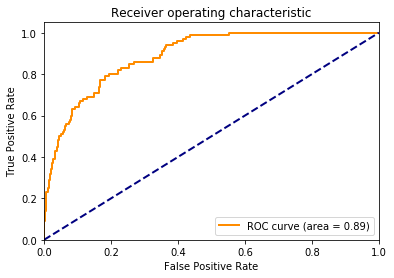

In [9]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_y[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_y.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# Showing Misclassification with a Confusion Matrix


In [9]:
from sklearn.metrics import confusion_matrix

labels = ["aircon","horn","child","dog","drill","engine","gun","hammer","siren","music"]
print ("Confusion_matrix")
cm = confusion_matrix(y_true, y_pred)

def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels]+[5]) # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print ("    " + empty_cell,)
    for label in labels: 
        print( "%{0}s".format(columnwidth) % label,)

    # Print rows
    for i, label1 in enumerate(labels):
        print ("    %{0}s".format(columnwidth) % label1,)
        for j in range(len(labels)): 
            cell = "%{0}s".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print (cell,)
      

print_cm(cm, labels)


Confusion_matrix
          
aircon
  horn
 child
   dog
 drill
engine
   gun
hammer
 siren
 music
    aircon
    60
     0
     0
     0
     0
     8
     0
    30
     1
     1
      horn
     3
    24
     0
     0
     3
     0
     0
     1
     0
     2
     child
     3
     1
    55
    17
     0
     2
     1
     0
    11
    10
       dog
     5
     0
    17
    59
     3
     3
     0
     3
     2
     8
     drill
     0
     0
     8
     0
    67
     0
     0
     8
    15
     2
    engine
    12
     0
    12
    12
     0
    50
     0
     0
     0
     7
       gun
     0
     0
     1
    15
     0
     0
    14
     0
     2
     0
    hammer
     3
     0
     4
     0
    44
     0
     0
    45
     0
     0
     siren
    18
     0
    12
     5
     1
     1
     0
     0
    46
     0
     music
    20
     3
     6
     1
    15
     3
     0
     1
     5
    46


# Refinement and Optimisation

The performance of a deep neural network is highly dependent on many configurable hyper-parameters, values that govern how the model actually works, and which are not changed during the course of learning. Some of these parameters will have a greater influence than others. The classic machine learning solution to this challenge is GridSearch, to successively train separate instances of a model with distinct values of key parameters, and then compare the resulting accuracy scores to identify which combination of parameters has produced the best results.

Scikit-Learn provides GridSearch functionality that can be adapted for use with a neural network implemented using Keras, as described here: http://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/.

Because the training process is computationally intensive, and must be repeated for each combination of hyper-parameter values, optimisation can be a slow, time-consuming process. The code below shows how the 3-layer network was trained with different stochastic gradient optimisers (https://keras.io/optimizers/), and reveals which algorithms work best for this particular problem domain

In [18]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.constraints import maxnorm

#activations = ['relu', 'tanh', 'linear']
#batch_sizes = [10, 20, 30, 40, 50, 60]
#epochs = [10, 20, 30]
dropout_rates = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

#optimisers = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']

model = KerasClassifier(build_fn=create_model, nb_epoch=5, batch_size=24, verbose=0)
model.fit(train_x, train_y)
# define the grid search parameters
# just using one here for illustration, but add activation_function=activations 
# or dropout_rate=dropout_rates to grid search on other parameters
param_grid = dict(dropout_rate = dropout_rates )
#param_grid = dict(optimiser=optimisers, activation_function=activations, dropout_rate = dropout_rates, batch_size= batch_sizes )
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)

print ("Running GridSearch...")
grid_result = grid.fit(train_x, train_y)
print ("GridSearch complete")

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


C:\Users\apt\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(193, input_dim=193, activation="relu", kernel_initializer="normal")`
  import sys
C:\Users\apt\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(400, activation="relu", kernel_initializer="normal")`
  if __name__ == '__main__':
C:\Users\apt\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(200, activation="relu", kernel_initializer="normal")`
  if sys.path[0] == '':
C:\Users\apt\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, activation="softmax", kernel_initializer="normal")`
  from ipykernel import kernelapp as app


Running GridSearch...
GridSearch complete
Best: 0.465602 using {'dropout_rate': 0.3}
0.465037 (0.038774) with: {'dropout_rate': 0.0}
0.448651 (0.031529) with: {'dropout_rate': 0.1}
0.456279 (0.024611) with: {'dropout_rate': 0.2}
0.465602 (0.018132) with: {'dropout_rate': 0.3}
0.437067 (0.012253) with: {'dropout_rate': 0.4}
0.403729 (0.025329) with: {'dropout_rate': 0.5}
0.398926 (0.024522) with: {'dropout_rate': 0.6}
0.323492 (0.032794) with: {'dropout_rate': 0.7}
0.268965 (0.024430) with: {'dropout_rate': 0.8}
0.170787 (0.024049) with: {'dropout_rate': 0.9}


# Generating Predictions

Once we've trained a model, we can use the following process to pass an audio file into our model and generate predictions, which will be the activation value (between 0 and 1) at the output layer for each of the 10 possible classes. Collectively, all the activations will sum to 1, meaning we can use argmax to show what the network's best guess is, as a well as providing a measure of its confidence.

The following fragment considers 10 different audio samples, one for each class, showing the model's best guess (highest activation value), as well as the second best guess, which can provide useful insights in those cases where the model misidentifies the sample. After all, as you can see from the results, the predictions are not perfect.

In [25]:
import librosa

sound_file_paths = ["57320-0-0-7.wav", "24074-1-0-3.wav", "15564-2-0-1.wav",  "7383-3-0-0.wav", "14113-4-0-0.wav",  "17592-5-0-0.wav",
                   "7061-6-0-0.wav","88466-7-0-0.wav","106905-8-0-2.wav", "21684-9-0-5.wav"]
sound_names = ["air conditioner","car horn","children playing","dog bark","drilling","engine idling",
               "gun shot","jackhammer","siren","street music"]
parent_dir = 'C:/Users/apt/Desktop/Data/UrbanSound8K/audio/'


# just extract the features, 
def extract_features_only(filename):
    features = np.empty((0,193))
    X, sample_rate = librosa.load(filename)
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
    ext_features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
    features = np.vstack([features,ext_features])
    return features

# create predictions for each of the sound classes
for s in range(len(sound_names)):

    print ("\n----- ", sound_names[s], "-----")
    # load audio file and extract features
    predict_file = parent_dir + sound_file_paths[s]
    predict_x = extract_features_only(predict_file)
    #print(predict_x)
    # generate prediction, passing in just a single row of features
    predictions = model.predict(predict_x)
    #print(predictions[1])
    #for i in range(len(predictions[0])):
    #    print sound_names[i], "=", round(predictions[0,i] * 100, 1)
    
    # get the indices of the top 2 predictions, invert into descending order
    ind = np.argpartition(predictions[0], -2)[-2:]
    ind[np.argsort(predictions[0][ind])]
    ind = ind[::-1]
    
    print ("Top guess: ", sound_names[ind[0]], " (",round(predictions[0,ind[0]],3),")")
    print ("2nd guess: ", sound_names[ind[1]], " (",round(predictions[0,ind[1]],3),")")



-----  air conditioner -----


ValueError: kth(=-1) out of bounds (1)

History keys: dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


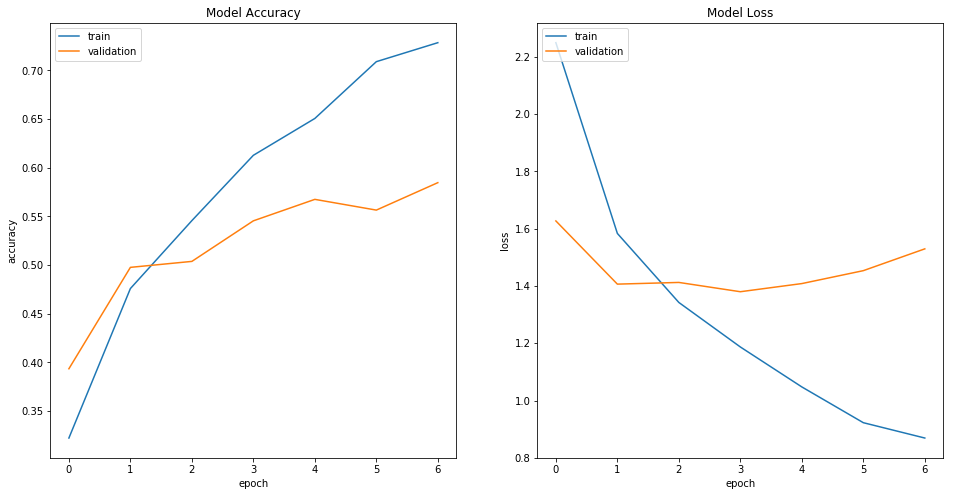

In [24]:
fig = plt.figure(figsize=(16,8))

print ("History keys:", (history.history.keys()))\\

# summarise history for training and validation set accuracy
plt.subplot(1,2,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

# summarise history for training and validation set loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Wave forms display for visualization

In [ ]:
sound_file_paths = ["a0001.wav","a0002.wav","a0003.wav","a0004.wav","a0005.wav",
                   "a0006.wav","a0007.wav","a0008.wav","a0009.wav","a0010.wav"]
sound_names = ["abnormal","abnormal","abnormal","abnormal","abnormal","abnormal",
               "normal","abnormal","normal","abnormal"]

raw_sounds = load_sound_files(sound_file_paths)

In [ ]:
plot_waves(sound_names,raw_sounds)
plot_specgram(sound_names,raw_sounds)
plot_log_power_specgram(sound_names,raw_sounds)
